# **Vehicle Detection on the Road** 


In [17]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split

%matplotlib inline

In [60]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def extract_features(imgs, cspace='RGB', hog_cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        #image = image.astype(np.float32)*255
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)    
            
        if hog_cspace != 'RGB':
            if hog_cspace == 'HSV':
                hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif hog_cspace == 'LUV':
                hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif hog_cspace == 'HLS':
                hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif hog_cspace == 'YUV':
                hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: hog_feature_image = np.copy(image)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(hog_feature_image.shape[2]):
                hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))
        #features.append(np.concatenate((hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, cspace='RGB', hog_cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256), orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):    
    #1) Define an empty list to receive features
    features = []
    #2) Apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: feature_image = np.copy(image)
        
    if hog_cspace != 'RGB':
        if hog_cspace == 'HSV':
            hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif hog_cspace == 'LUV':
            hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif hog_cspace == 'HLS':
            hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif hog_cspace == 'YUV':
            hog_feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    else: hog_feature_image = np.copy(image)   
    # Apply bin_spatial() to get spatial color features
    spatial_features = bin_spatial(feature_image, size=spatial_size)
    # Apply color_hist() also with a color space option now
    hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
    # Call get_hog_features() with vis=False, feature_vec=True
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(hog_feature_image.shape[2]):
            hog_features.append(get_hog_features(hog_feature_image[:,:,channel], 
                                orient, pix_per_cell, cell_per_block, 
                                vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(hog_feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
    # Append the new feature vector to the features list
    features.append(np.concatenate((spatial_features, hist_features, hog_features)))
    #features.append(np.concatenate((hist_features, hog_features)))
    # Return list of feature vectors
    return features

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', hog_color_space='HSV',
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, cspace=color_space, hog_cspace=hog_color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins, hist_range=hist_range, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, 
              cell_per_block, spatial_size, hist_bins, hist_range, hog_channel):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='HSV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog = get_hog_features(ctrans_tosearch[:,:,hog_channel], orient, pix_per_cell, cell_per_block, feature_vec=False)
    hot_windows = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins, bins_range=hist_range)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                curr_window = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                hot_windows.append(curr_window)
                
    return draw_img, hot_windows

In [61]:
cars_kitti = glob.glob('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/vehicles/KITTI_extracted/*.png')
print(len(cars_kitti))
notcars_kitti = glob.glob('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/non-vehicles/Extras/*.png')
print(len(notcars_kitti))
cars_gti = glob.glob('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/vehicles/GTI*/*.png')
print(len(cars_gti))
notcars_gti = glob.glob('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Vehicle-Detection/non-vehicles/GTI/*.png')
print(len(notcars_gti))
from sklearn.utils import shuffle
cars_gti = shuffle(cars_gti)
cars_gti = cars_gti[0:1000]
print(len(cars_gti))
notcars_gti = shuffle(notcars_gti)
notcars_gti = notcars_gti[0:1000]
print(len(notcars_gti))

5966
5068
2826
3900
1000
1000


In [84]:
spatial = 32
histbin = 64
colorspace = 'HSV'
hog_colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = extract_features(cars_kitti, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars_kitti, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

test_car_features = extract_features(cars_gti, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
test_notcar_features = extract_features(notcars_gti, cspace=colorspace, hog_cspace=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256), orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

42.74 Seconds to extract features...


In [87]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_test = np.vstack((test_car_features, test_notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
#X_test_scaler = StandardScaler().fit(X_test)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
scaled_X_test = X_scaler.transform(X_test)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
y_t = np.hstack((np.ones(len(test_car_features)), np.zeros(len(test_notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
#X_train, X_test, y_train, y_test = train_test_split(
#    scaled_X, y, test_size=0.2, random_state=rand_state)

# train_test_split on data yielded poor results since same images
# were repeated in test data. So manually splitting training 
# and test images from different directories to not have any overlap
X_train = scaled_X
y_train = y
X_test = scaled_X_test
y_test = y_t

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

# Use Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=30, min_samples_leaf=2)
t=time.time()
clf = clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train RFC...')
# Check the score of the SVC
print('Test Accuracy of RFC = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My RFC predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with RFC')

Using spatial binning of: 32 and 64 histogram bins
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5028
5.06 Seconds to train SVC...
Test Accuracy of SVC =  0.6
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00302 Seconds to predict 10 labels with SVC
23.94 Seconds to train RFC...
Test Accuracy of RFC =  0.621
My RFC predicts:  [ 0.  1.  1.  0.  0.  0.  0.  0.  1.  0.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
0.00597 Seconds to predict 10 labels with RFC


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

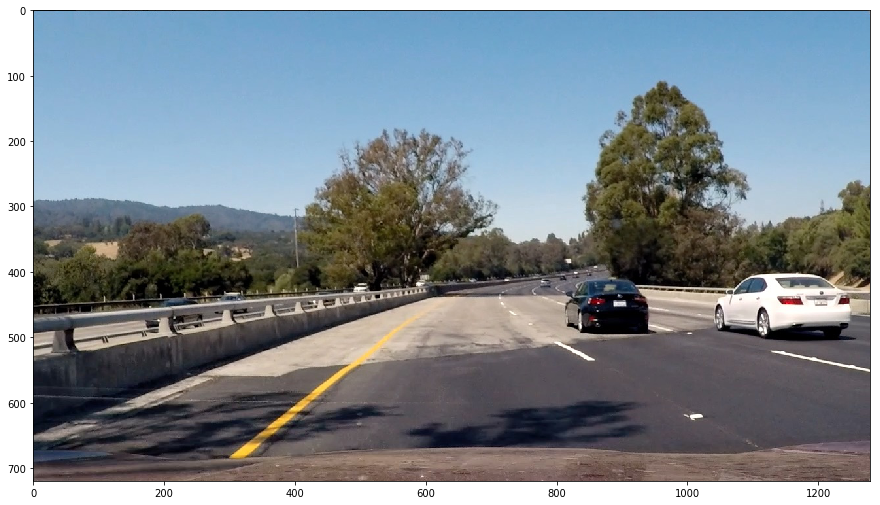

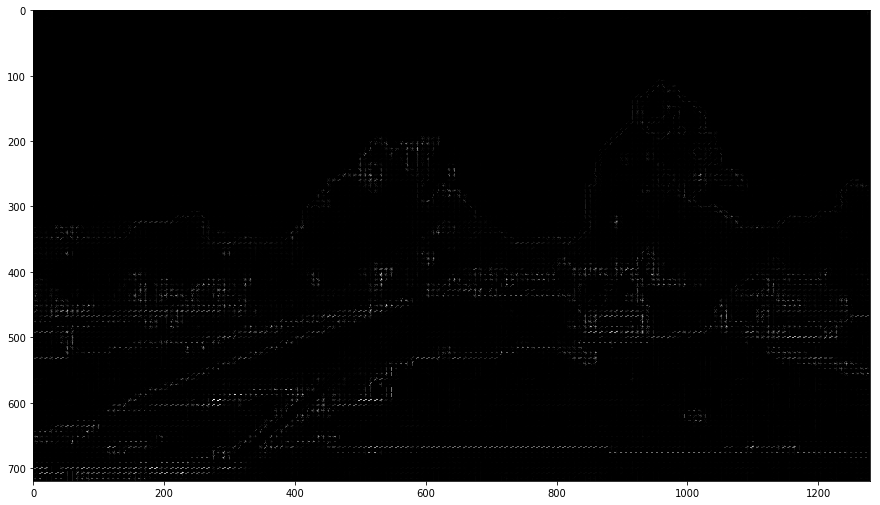

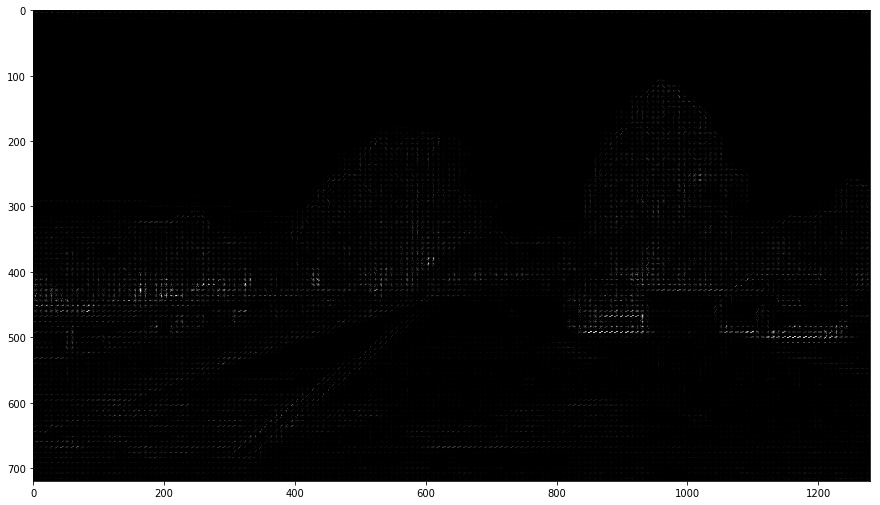

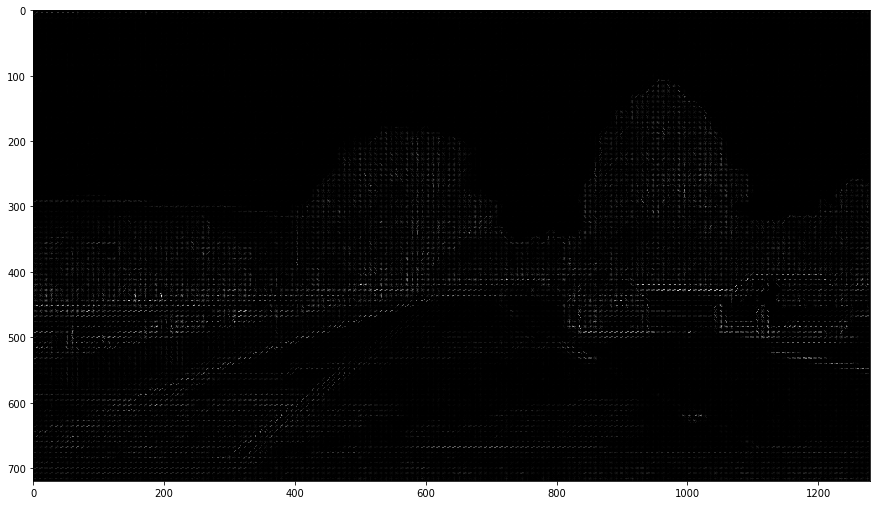

In [83]:
image = mpimg.imread('test4.jpg')
plt.figure(figsize=(15,15)); plt.imshow(image)
draw_image = np.copy(image)
img_shape = image.shape
#print(image)
image = image.astype(np.float32)/255
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
hog_features, hog_image = get_hog_features(image[:,:,0], 9, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.figure(figsize=(15,15)); plt.imshow(hog_image, cmap='gray')
hog_features, hog_image = get_hog_features(image[:,:,1], 9, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.figure(figsize=(15,15)); plt.imshow(hog_image, cmap='gray')
hog_features, hog_image = get_hog_features(image[:,:,2], 9, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
plt.figure(figsize=(15,15)); plt.imshow(hog_image, cmap='gray')


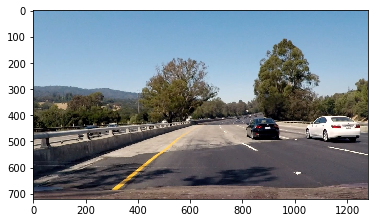

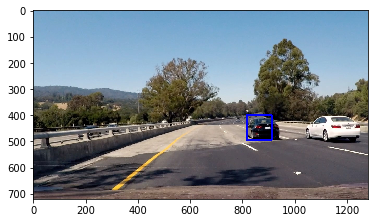

In [85]:
image = mpimg.imread('test4.jpg')
plt.figure(); plt.imshow(image)
draw_image = np.copy(image)
img_shape = image.shape
# convert jpg test to png training
image = image.astype(np.float32)/255

y_start_stop = [400, 656] # Min and max in y to search in slide_window()
#spatial = 32
#histbin = 64
#colorspace = 'HSV'
#hog_colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
#orient = 9
#pix_per_cell = 8
#cell_per_block = 2
#hog_channel = 1 # Can be 0, 1, 2, or "ALL"

final_windows = []
#for i in range(3):
#    #win_size = 64 + 32*i
win_size = 96
#    print("current window size: ", win_size)
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(win_size, win_size), xy_overlap=(0.5, 0.5))
#    final_windows = final_windows + windows
#print(len(final_windows))
#print(len(windows))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                        hog_color_space=hog_colorspace, spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
plt.imshow(window_img)

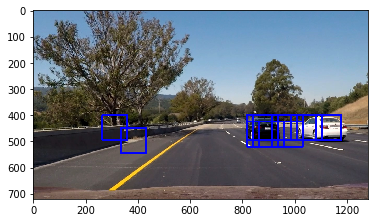

In [110]:
ystart = 400
ystop = 656
scale = 1.5

img = mpimg.imread('test6.jpg')
out_img, hot_windows = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                    pix_per_cell, cell_per_block, (spatial, spatial), histbin, (0, 256), hog_channel)

plt.imshow(out_img)

2 cars found


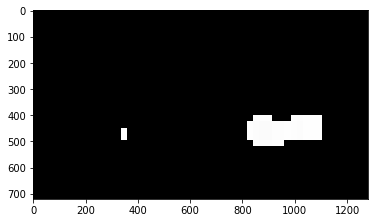

In [111]:
heatmap = np.zeros(img_shape)
heatmap = add_heat(heatmap, hot_windows)
heatmap = apply_threshold(heatmap, 1)
plt.figure(); plt.imshow(heatmap)
from scipy.ndimage.measurements import label
labels = label(heatmap)
print(labels[1], 'cars found')
#plt.imshow(labels[0], cmap='gray')

In [4]:
# Calibrate camera
camera_objpoints, camera_imgpoints = calibrate_camera()

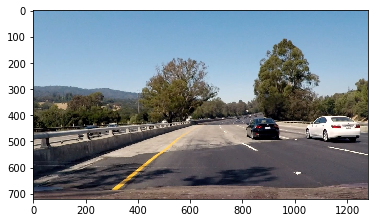

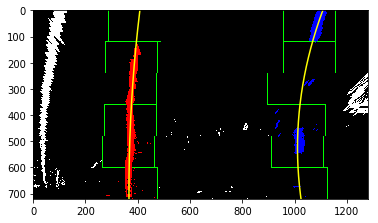

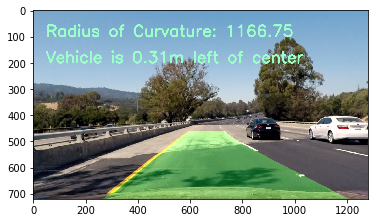

In [18]:
# Undistort image
#orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/camera_cal/calibration1.jpg')
#plt.figure(); plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
#undistorted_image = undistort_image(orig_image, camera_objpoints, camera_imgpoints)

#orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg')
orig_image = cv2.imread('/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/test_images/test4.jpg')
plt.figure(); plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
undistorted_image = undistort_image(orig_image, camera_objpoints, camera_imgpoints)
binary_thresh_image = color_threshold(undistorted_image)
binary_warped_image, Minv = transform_perspective(binary_thresh_image)
left_fit, right_fit = fit_lane_lines(binary_warped_image)
left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit, right_fit)
inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit, right_fit, Minv)
dist_off_center_str = get_off_center_distance(binary_warped_image)
final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
plt.figure(); plt.imshow(cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB))

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
import moviepy

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Calibrate camera
camera_objpoints, camera_imgpoints = calibrate_camera()

In [8]:
def process_image(image):
    undistorted_image = undistort_image(image, camera_objpoints, camera_imgpoints)
    binary_thresh_image = color_threshold(undistorted_image)
    binary_warped_image, Minv = transform_perspective(binary_thresh_image)
    left_fit_next, right_fit_next = fit_lane_lines(binary_warped_image)
    left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit_next, right_fit_next)
    inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit_next, right_fit_next, Minv)
    dist_off_center_str = get_off_center_distance(binary_warped_image)
    final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
    #print(final_image.shape)
    return final_image

first_fit = 0
left_fit_previous = np.zeros(3)
right_fit_previous = np.zeros(3)
left_fit_next = np.zeros(3)
right_fit_next = np.zeros(3)

def process_image_new(image):
    global first_fit, left_fit_previous, right_fit_previous
    global left_fit_next, right_fit_next
    undistorted_image = undistort_image(image, camera_objpoints, camera_imgpoints)
    binary_thresh_image = color_threshold(undistorted_image)
    binary_warped_image, Minv = transform_perspective(binary_thresh_image)
    if (first_fit == 0):
        #print("left_fit_previous first: ", left_fit_previous)
        #print("right_fit_previous first: ", right_fit_previous)
        left_fit_next, right_fit_next = fit_lane_lines(binary_warped_image)
        first_fit = 1
        left_fit_previous = left_fit_next
        right_fit_previous = right_fit_next
    else:
        #print("left_fit_previous: ", left_fit_previous)
        #print("right_fit_previous: ", right_fit_previous)
        left_fit_next, right_fit_next = fit_new_lane_lines(binary_warped_image, left_fit_previous, right_fit_previous)
        left_fit_previous = left_fit_next
        right_fit_previous = right_fit_next
    #print("left_fit_next: ", left_fit_next)
    #print("right_fit_next: ", right_fit_next)
    left_rad, right_rad = get_radius_curvature(binary_warped_image, left_fit_next, right_fit_next)
    inv_persp_image = transform_inv_perspective(undistorted_image, binary_warped_image, left_fit_next, right_fit_next, Minv)
    dist_off_center_str = get_off_center_distance(binary_warped_image)
    final_image = add_data_to_image(inv_persp_image, dist_off_center_str, left_rad, right_rad)
    #print(final_image.shape)
    return final_image

Let's try the one with the solid white lane on the right first ...

In [9]:
moviepy.__version__

'0.2.2.13'

In [10]:
last_frame_left = None
last_frame_right = None

white_output = '/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/project_video_output.mp4'
clip1 = VideoFileClip("/Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/project_video.mp4")
#print(clip1.get_frame(0).shape)
white_clip = clip1.fl_image(process_image_new) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'moviepy.video.io.VideoFileClip.VideoFileClip'>
[[[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 78 128 176]
  [ 77 127 175]
  [ 77 127 175]]

 [[106 147 188]
  [106 147 188]
  [106 147 188]
  ..., 
  [ 78 128 176]
  [ 77 127 175]
  [ 77 127 175]]

 [[107 148 189]
  [107 148 189]
  [107 148 189]
  ..., 
  [ 78 128 176]
  [ 77 127 175]
  [ 77 127 175]]

 ..., 
 [[103  85 103]
  [102  85 103]
  [102  86 104]
  ..., 
  [108  86  78]
  [111  89  81]
  [112  90  82]]

 [[106  88 105]
  [104  87 104]
  [104  87 103]
  ..., 
  [108  86  78]
  [113  91  83]
  [116  94  86]]

 [[106  89 100]
  [105  88  99]
  [105  88  99]
  ..., 
  [109  87  80]
  [113  91  84]
  [118  96  88]]]
[MoviePy] >>>> Building video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/project_video_output.mp4
[MoviePy] Writing video /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/proje

100%|█████████▉| 1260/1261 [15:39<00:00,  1.29it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /Users/SandeepGangundi/Documents/Courses/Udacity/Self_Driving_Car_ND/Term1/Udacity-CarND-Advanced-Lane-Lines/project_video_output.mp4 

CPU times: user 16min 15s, sys: 46.5 s, total: 17min 2s
Wall time: 15min 40s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:13<00:00, 51.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 12.3 s, sys: 2.71 s, total: 15 s
Wall time: 13.7 s


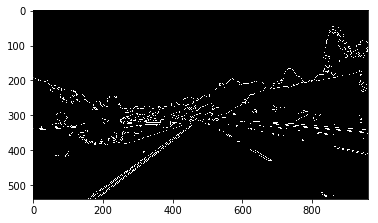

In [35]:
last_frame_left = None
last_frame_right = None

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


Lane Detection Pipeline:
- First I converted the image to grayscale and added Gaussian blur to the image.
- Then I found edges in the image, by using canny edge detection. Worked trying out few min/max parameters for canny and found 50/150 to be a good choice.
- Since we are interested in only the lanes, we need to filter our that particular region by masking out the image. So I masked out only the lanes.
- After masking, I calucated Hough transform of the image to find out long continuous lines of the lanes and ignore all other lines in the image.
- Until here we have the lines of lanes that we are interested, so finally just merge these lines with the original image by adding both together with appropriate weights.
- Finally save the image.

For images, it was challenging to save the image using cv2 because the default image color depth was BGR and cv2.write expects RGB while saving, so I had to figure out a way to do that and finally use below code:

cv2.imwrite(new_file, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))

For videos however I did not have to do this conversion and BGR color depth worked fine.

Future work:
I think right now in video mode, the lane lines detected flicker between the frames. I can enhance this to ignore small changes in the lines to avoid flickering.
For optional challenge, first obstacle was getting the masked region right, so I had to calculate coordinates of the region relative to the image size. The second obstable I am facing right now is during calculating Hough Transform. I need to ignore the horizontal lines and consider only the slant ones, I will try working on it but meanwhile would want to go ahead and submit this project.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:13<00:00, 19.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 18.1 s, sys: 4.47 s, total: 22.6 s
Wall time: 14 s


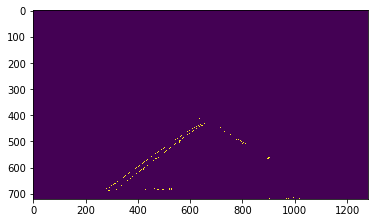

In [37]:
last_frame_left = None
last_frame_right = None

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image_new)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))